# Multi-armed bandit problem

The following is a simple implementation of the **multi-armed bandit problem**. The problem is as follows. You are faced with $k$ distributions (or *arms*) which are not known to you. As an example, these could be several variations of *high-frequency trading algorithms* with unknown rewards. You can sample from these distributions, and you want to *maximize your reward*, i.e. maximize your average return over time.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from bandits.arms import NormalArm
from bandits.bandits import EpsilonGreedyBandit, GreedyBandit, UpperConfidenceBoundBandit
from bandits.plots import set_plot_style

In [8]:
# Set plotting style
set_plot_style()

In [9]:
# Set random seed for reproducibility
SEED = 42

There are several variations of bandit algorithms, see [Sutton, Barto (2015)](https://inst.eecs.berkeley.edu//~cs188/sp20/assets/files/SuttonBartoIPRLBook2ndEd.pdf). Currently, I have implemented the following:
- **Greedy bandit algorithm** - The simplest bandit algorithm which always chooses the arm with the highest estimated reward.
- **Epsilon-greedy bandit algorithm** - A simple bandit algorithm which chooses the arm with the highest estimated reward with probability 1-epsilon, and chooses a random arm with probability epsilon.
- **Upper confidence bound (UCB) bandit algorithm** - A bandit algorithm which chooses the arm with the highest estimated reward plus a bonus term which depends on the number of times the arm has been sampled. This bonus term is chosen to be larger for arms which have been sampled few times, and small for arms which have been sampled many times.

In [10]:
# Initialize arms
means = [0.05, 0.3, 0.01]
sigmas = [0.1, 1, 0]
arms = [NormalArm(mu, sigma, seed=SEED) for mu, sigma in zip(means, sigmas)]
k = len(arms)


In [11]:
# Initialize bandits
bandits = [
    GreedyBandit(k=k, label="Greedy", seed=SEED),
    EpsilonGreedyBandit(k=k, label="Eps greedy", epsilon=0.05, seed=SEED),
    UpperConfidenceBoundBandit(k=k, label="UCB", c=0.5, seed=SEED),
]

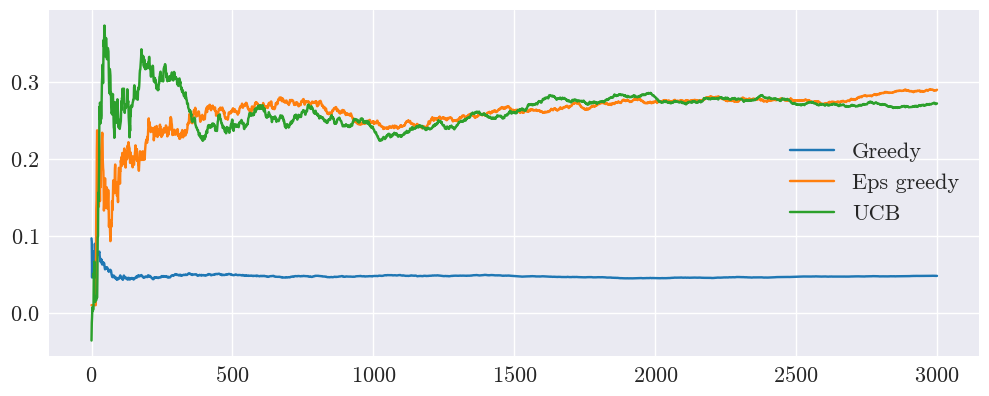

In [12]:
# Run the simulation
for _ in range(3010):
    for bandit in bandits:
        arm = bandit.select_arm()
        reward = arms[arm].sample()
        bandit.update(arm, reward)

# Plot the results
fig = plt.figure(figsize=(12, 4.5))
for bandit in bandits:
    rewards = np.array(bandit.rewards)[10:]    
    plt.plot(np.cumsum(rewards) / np.arange(1, len(rewards) + 1), label=bandit.label)
plt.legend()
plt.show()